Importing the required libraries

In [160]:
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import pathlib
import os
import zipfile
import tensorflow as tf
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

from keras.utils import image_dataset_from_directory
from keras.models import Sequential, load_model
from keras import layers
from keras.applications import EfficientNetV2B0
from keras.metrics import AUC, Precision, Recall
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

Dataset: Retinal Fundus Multi-Disease Image Dataset (RFMID)

It consists of

1. Original color fundus images (3200 images divided into a training set (1920 images), validation (640 images), and testing set (640 images) - PNG Files)

2.  Groundtruth Labels for normal and abnormal (comprising of 45 different types of diseases/pathologies) categories (Divided into training, validation, and testing set - CSV Files)

https://ieee-dataport.org/open-access/retinal-fundus-multi-disease-image-dataset-rfmid

Notes: 

1. Make sure to mount your Google Drive to load this data and use the kaggle.json available along with this notebook
2. Please properly set all the paths depending on which directroy in your drive you plan to run it and have this notebook saved

In [3]:
!cp '/content/drive/MyDrive/kaggle.json' '/content'
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
!kaggle datasets download -d andrewmvd/retinal-disease-classification

100% 7.42G/7.43G [01:09<00:00, 53.2MB/s]
100% 7.43G/7.43G [01:09<00:00, 115MB/s] 


In [4]:
zip_ref = zipfile.ZipFile('retinal-disease-classification.zip', 'r') 
zip_ref.extractall('/content') 
zip_ref.close()

In [45]:
train_df = pd.read_csv('/content/Training_Set/Training_Set/RFMiD_Training_Labels.csv')
val_df = pd.read_csv('/content/Evaluation_Set/Evaluation_Set/RFMiD_Validation_Labels.csv')
test_df = pd.read_csv('/content/Test_Set/Test_Set/RFMiD_Testing_Labels.csv')

In [46]:
def check_disease(df):
    disease, pos = [], []
    rowLen = len(df)
    for (column_name, column) in df.items():
        disease.append(column_name)    
        pos.append(rowLen - (df[column_name].value_counts()[0]))
    
    return disease, pos

Removing 'Disease Risk' column to use different labels provided and not treat it as a binary problem. Removing all abnormalities that had less than 125 labels in the dataset.

In [47]:
train_df_1 = train_df.drop(['ID', 'Disease_Risk'], axis=1)
val_df_1 = val_df.drop(['ID', 'Disease_Risk'], axis=1)
test_df_1 = test_df.drop(['ID', 'Disease_Risk'], axis=1)

disease, pos_count = check_disease(train_df_1)

for i in range(len(train_df_1.columns)):
    if pos_count[i] <= 125:
        train_df_1 = train_df_1.drop([disease[i]], axis=1)
        val_df_1 = val_df_1.drop([disease[i]], axis=1)
        test_df_1 = test_df_1.drop([disease[i]], axis=1)

disease_1 = []

for (column_name, column) in train_df_1.items():
    disease_1.append(column_name)

train_df_1['Sum'] = train_df_1.sum(axis=1)
train_df_1 = train_df_1[train_df_1['Sum'] <= 1]

val_df_1['Sum'] = val_df_1.sum(axis=1)
val_df_1 = val_df_1[val_df_1['Sum'] <= 1]

test_df_1['Sum'] = test_df_1.sum(axis=1)
test_df_1 = test_df_1[test_df_1['Sum'] <= 1]

Modifying the dataset to make it a multi-class classification problem instead of a multi-label problem by removing cases having more than one abnormality. All normal cases (having no disease) were grouped into 'No Disease (ND)' class.

In [48]:
train_df_1.loc[train_df_1['Sum'] == 0, 'ND'] = 1
train_df_1.loc[train_df_1['Sum'] == 1, 'ND'] = 0
train_df_1['ND'] = train_df_1['ND'].astype(int)
disease_1.append('ND')
train_df_1 = train_df_1.drop(['Sum'], axis=1)

val_df_1.loc[val_df_1['Sum'] == 0, 'ND'] = 1
val_df_1.loc[val_df_1['Sum'] == 1, 'ND'] = 0
val_df_1['ND'] = val_df_1['ND'].astype(int)
val_df_1 = val_df_1.drop(['Sum'], axis=1)

test_df_1.loc[test_df_1['Sum'] == 0, 'ND'] = 1
test_df_1.loc[test_df_1['Sum'] == 1, 'ND'] = 0
test_df_1['ND'] = test_df_1['ND'].astype(int)
test_df_1 = test_df_1.drop(['Sum'], axis=1)

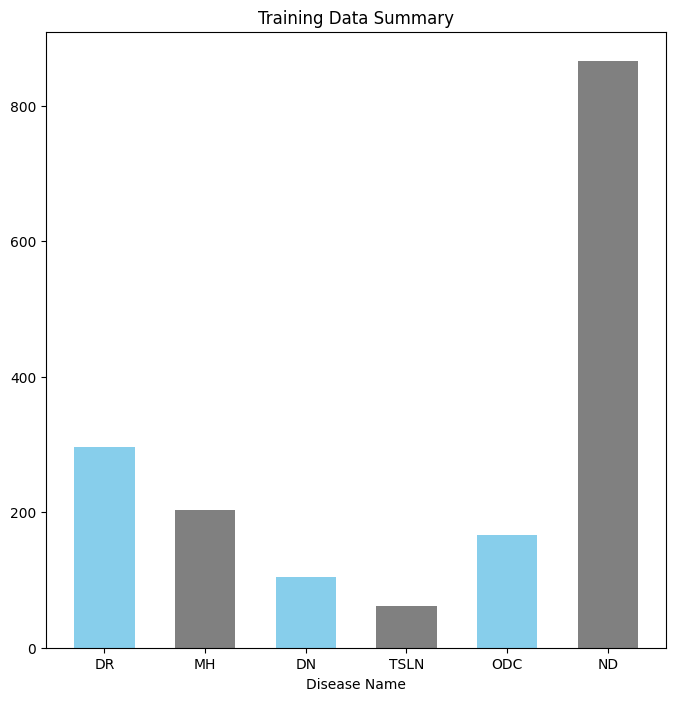

DR appears: 297
MH appears: 204
DN appears: 105
TSLN appears: 62
ODC appears: 167
ND appears: 866


In [157]:
disease_temp, pos_count_temp = check_disease(train_df_1)

fig = plt.figure(figsize=(8, 8))
plt.bar(disease_temp, pos_count_temp, width=0.6, color=['skyblue', 'gray'])
plt.title('Training Data Summary')
plt.xlabel('Disease Name')
plt.show()

for i in range(len(disease_temp)):
    print(str(disease_temp[i]) + ' appears: '+ str(pos_count_temp[i]))

Making appropriate folders and transfering images to their corresponding class folders for training, validation, and test data

In [9]:
data_dir = '/content/Training_Set/Training_Set/Training_1/'
val_data_dir = '/content/Evaluation_Set/Evaluation_Set/Evaluation_1/'

os.mkdir(data_dir)
os.mkdir(val_data_dir)

dis_list = []
val_dis_list = []

for i in disease_1:
  os.mkdir(data_dir + i)
  os.mkdir(val_data_dir + i)
  dis_list.append(train_df_1[i].isin([1]).tolist())
  val_dis_list.append(val_df_1[i].isin([1]).tolist())

train_df_1['ID'] = train_df_1.index + 1
train_df_1['img_path'] = [f'/content/Training_Set/Training_Set/Training/{id}.png' for id in train_df_1['ID']]
train_img_list = train_df_1['img_path'].tolist()

val_df_1['ID'] = val_df_1.index + 1
val_df_1['img_path'] = [f'/content/Evaluation_Set/Evaluation_Set/Validation/{id}.png' for id in val_df_1['ID']]
val_img_list = val_df_1['img_path'].tolist()

for i in range(len(dis_list)):
  for j in range(len(dis_list[i])):
    if dis_list[i][j]:
      shutil.copy(train_img_list[j], data_dir + disease_1[i])

for i in range(len(val_dis_list)):
  for j in range(len(val_dis_list[i])):
    if val_dis_list[i][j]:
      shutil.copy(val_img_list[j], val_data_dir + disease_1[i])

In [49]:
test_data_dir = '/content/Test_Set/Test_Set/Test_1/'

os.mkdir(test_data_dir)

test_dis_list = []

for i in disease_1:
  os.mkdir(test_data_dir + i)
  test_dis_list.append(test_df_1[i].isin([1]).tolist())

test_df_1['ID'] = test_df_1.index + 1
test_df_1['img_path'] = [f'/content/Test_Set/Test_Set/Test/{id}.png' for id in test_df_1['ID']]
test_img_list = test_df_1['img_path'].tolist()

for i in range(len(test_dis_list)):
  for j in range(len(test_dis_list[i])):
    if test_dis_list[i][j]:
      shutil.copy(test_img_list[j], test_data_dir + disease_1[i])

In [168]:
IMG_SIZE = 224

train_ds = image_dataset_from_directory(data_dir, batch_size = 64)
val_ds = image_dataset_from_directory(val_data_dir, batch_size = 64)
test_ds = image_dataset_from_directory(test_data_dir, batch_size = 64)

NUM_CLASSES = len(train_ds.class_names)
class_names = train_ds.class_names
size = (IMG_SIZE, IMG_SIZE)

Found 1701 files belonging to 6 classes.
Found 566 files belonging to 6 classes.
Found 555 files belonging to 6 classes.


Displaying 50 randomly sampled training example images

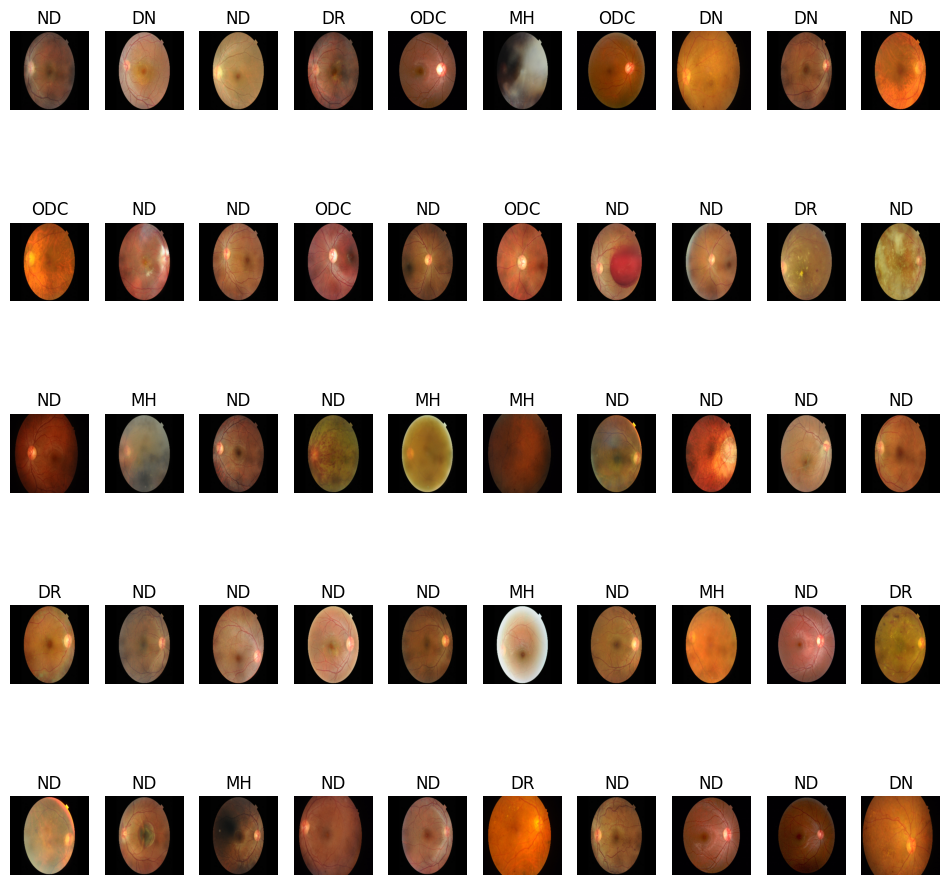

In [158]:
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
  for i in range(50):
    ax = plt.subplot(5, 10, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

**Qualitative observations about the abnormalities**:

1. Drusens (DN) are yellow or white extracellular deposits 
2. Diabetic retinopathy (DR) shows cotton wool spots
3. Media Haze (MH) is characterized by opacity and also includes other artifacts from acquisition procedures
4. Optic disc cupping (ODC), the optic disc appears excavated
5. In Tessellation (TSLN) images, choroidal vessels are visible due to the reduced pigment density 

In [169]:
train_ds = train_ds.map(lambda image, label: (tf.image.resize(image, size), label))
val_ds = val_ds.map(lambda image, label: (tf.image.resize(image, size), label))
test_ds = test_ds.map(lambda image, label: (tf.image.resize(image, size), label))

Resized the images to fit the EfficientNet model requirement and also performing image augmentation to handle class imbalance

In [15]:
img_augmentation = Sequential(
    [
        layers.RandomRotation(0.1),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomZoom(0.1),
        layers.RandomContrast(factor=0.1),
    ],
    name='img_augmentation',
)

Encoding multi-class labels 

In [170]:
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds = train_ds.map(input_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(input_preprocess)
test_ds = test_ds.map(input_preprocess)

Using EfficientNetV2B0 model exisiting in Keras. Due to limited time available for training, fine-tuning a pre-trained model rather than training from scratch. Also, this would be beneficial since the EfficientNet model was also training based on ImageNet that has the advantage of huge data

As the first step, freezing all layers and training only the top layers.

Used AUC as main metric for classification as it is unaffected by class prevelance unlike accuracy

In [23]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = EfficientNetV2B0(include_top=False, input_tensor=x, weights="imagenet")

    model.trainable = False
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=[AUC(), Precision(), Recall()])
    return model

In [24]:
model = build_model(num_classes=NUM_CLASSES)

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp = ModelCheckpoint('/content/drive/MyDrive/model.h5', save_best_only=True, monitor='val_loss', mode='min')

hist = model.fit(train_ds, epochs=15, validation_data=val_ds, callbacks=[earlyStopping, mcp], verbose=2)

Epoch 1/15
54/54 - 450s - loss: 1.9550 - auc_1: 0.8290 - precision_1: 0.5541 - recall_1: 0.5062 - val_loss: 1.7012 - val_auc_1: 0.8203 - val_precision_1: 0.5573 - val_recall_1: 0.5495 - 450s/epoch - 8s/step
Epoch 2/15
54/54 - 430s - loss: 1.7905 - auc_1: 0.8548 - precision_1: 0.5985 - recall_1: 0.5714 - val_loss: 1.8011 - val_auc_1: 0.8614 - val_precision_1: 0.5471 - val_recall_1: 0.5442 - 430s/epoch - 8s/step
Epoch 3/15
54/54 - 378s - loss: 1.6524 - auc_1: 0.8666 - precision_1: 0.6315 - recall_1: 0.5914 - val_loss: 1.6141 - val_auc_1: 0.8757 - val_precision_1: 0.5832 - val_recall_1: 0.5760 - 378s/epoch - 7s/step
Epoch 4/15
54/54 - 439s - loss: 1.5413 - auc_1: 0.8768 - precision_1: 0.6248 - recall_1: 0.5855 - val_loss: 1.0934 - val_auc_1: 0.9024 - val_precision_1: 0.6967 - val_recall_1: 0.6290 - 439s/epoch - 8s/step
Epoch 5/15
54/54 - 429s - loss: 1.5559 - auc_1: 0.8734 - precision_1: 0.6364 - recall_1: 0.6008 - val_loss: 1.2134 - val_auc_1: 0.8857 - val_precision_1: 0.6161 - val_recal

As the second step, unfreezing 20 layers and fitting the model using smaller learning rate.

In [25]:
def unfreeze_model(model):
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=[AUC(), Precision(), Recall()])

unfreeze_model(model)

mcp_1 = ModelCheckpoint('/content/drive/MyDrive/model_1.h5', save_best_only=True, monitor='val_loss', mode='min')

hist = model.fit(train_ds, epochs=15, validation_data=val_ds, callbacks=[earlyStopping, mcp_1], verbose=2)

Epoch 1/15
54/54 - 407s - loss: 0.9110 - auc_2: 0.9215 - precision_2: 0.7150 - recall_2: 0.6267 - val_loss: 0.9708 - val_auc_2: 0.9144 - val_precision_2: 0.7214 - val_recall_2: 0.6131 - 407s/epoch - 8s/step
Epoch 2/15
54/54 - 398s - loss: 0.8626 - auc_2: 0.9295 - precision_2: 0.7331 - recall_2: 0.6426 - val_loss: 0.9439 - val_auc_2: 0.9198 - val_precision_2: 0.7262 - val_recall_2: 0.6325 - 398s/epoch - 7s/step
Epoch 3/15
54/54 - 436s - loss: 0.8589 - auc_2: 0.9306 - precision_2: 0.7343 - recall_2: 0.6549 - val_loss: 0.9359 - val_auc_2: 0.9237 - val_precision_2: 0.7260 - val_recall_2: 0.6555 - 436s/epoch - 8s/step
Epoch 4/15
54/54 - 379s - loss: 0.8146 - auc_2: 0.9362 - precision_2: 0.7408 - recall_2: 0.6602 - val_loss: 0.9220 - val_auc_2: 0.9247 - val_precision_2: 0.7296 - val_recall_2: 0.6484 - 379s/epoch - 7s/step
Epoch 5/15
54/54 - 451s - loss: 0.7680 - auc_2: 0.9432 - precision_2: 0.7731 - recall_2: 0.6872 - val_loss: 0.9134 - val_auc_2: 0.9246 - val_precision_2: 0.7233 - val_recal

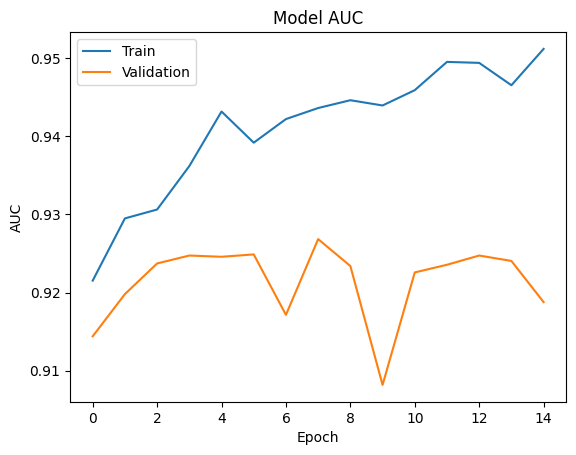

In [26]:
def plot_hist(hist):
    plt.plot(hist.history['auc_2'])
    plt.plot(hist.history['val_auc_2'])
    plt.title('Model AUC')
    plt.ylabel('AUC')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_hist(hist)

Losd the model

In [161]:
model = load_model('/content/drive/MyDrive/model_1.h5')

Evaluate the model

In [171]:
[loss, auc, p, r] = model.evaluate(test_ds)

9/9 [==============================] - 128s 6s/step - loss: 0.8772 - auc_2: 0.9303 - precision_2: 0.7465 - recall_2: 0.6631


In [172]:
predictions = model.predict(test_ds, verbose=1)

a, b = predictions.shape
for i in range(a):
  thres = np.max(predictions[i])
  y_pred[i] = (predictions[i] >= thres)*1 

y_true = np.concatenate([y for x, y in test_ds], axis=0)

9/9 [==============================] - 108s 4s/step


In [147]:
class_names_1 = ['Drusen', 'Diabetic Retinopathy', 'Media Haze', 'No Disease', 'Optic Disc Cupping', 'Tessellation']

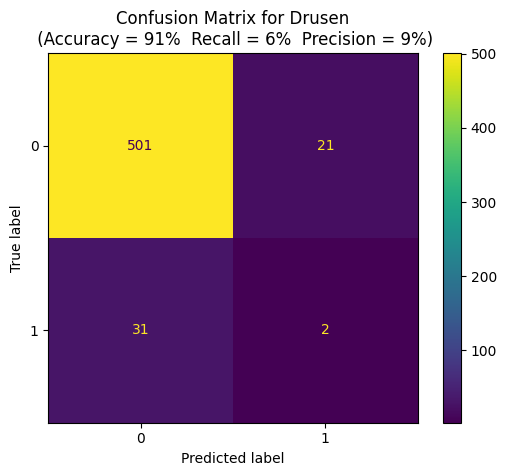

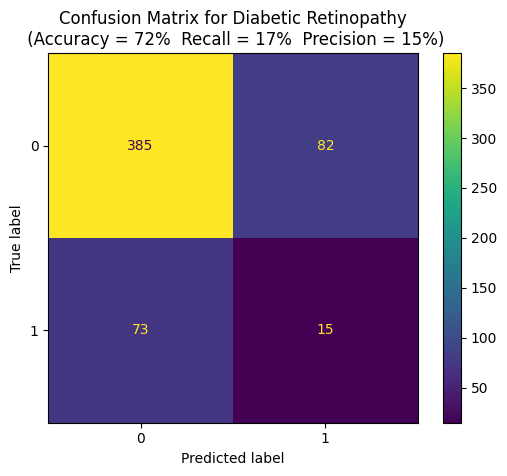

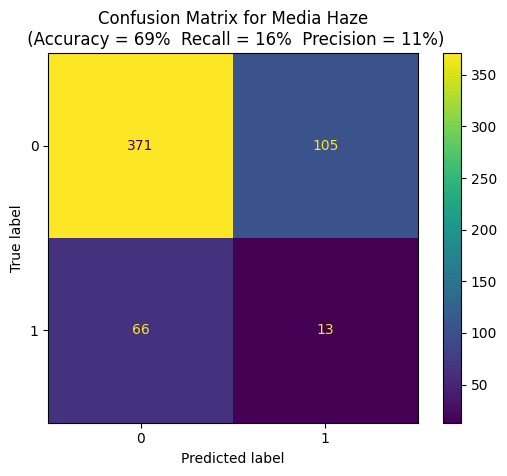

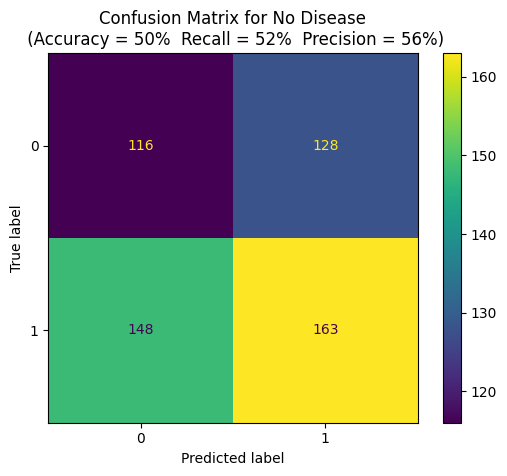

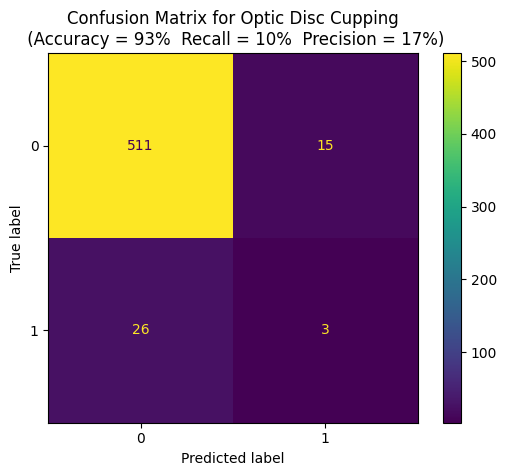

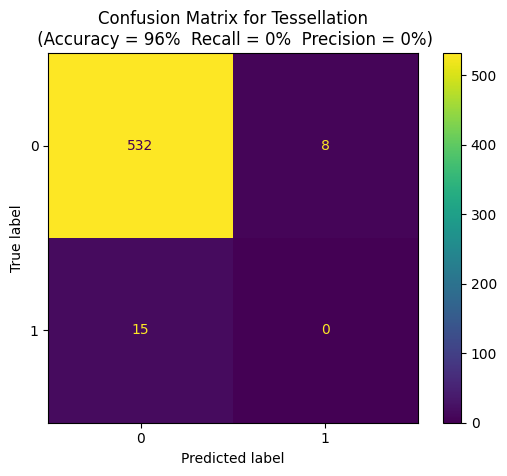

In [149]:
cm = multilabel_confusion_matrix(y_true, y_pred)
n = 0
for i in class_names_1:
  disp = ConfusionMatrixDisplay(cm[n])
  acc = round(((cm[n][0,0] + cm[n][1,1]) * 100)/sum(sum(cm[n])))
  p = round((cm[n][1,1] * 100) / (cm[n][1,1] + cm[n][0,1]))
  r = round((cm[n][1,1] * 100) / (cm[n][1,1] + cm[n][1,0]))
  disp.plot()
  plt.title('Confusion Matrix for ' + i + '\n' + f' (Accuracy = {acc}%  Recall = {r}%  Precision = {p}%)')
  n = n + 1 

**Summary**:

The model overall achieved 93% AUC, 75% precision 75%, and 66% recall.

Accuracies, precision, and recall per class are summarized in the confusion matrices shown above. 

**Discussion**:
1. The model was trained for very less epochs due to limited computational resources and time
2. The precision and recall values per class are too low and seem to be directly impacted by the number of labels available for that class (Eg: TSLN has the lowest number of labels and also the lowest precision and recall)
3. The presented model would perform well for stratifying disease vs. no disease. However, to identify different disease classes, this model is weak and needs further training
4. Further exploration is needed on the image pre-processing side. Since it is trained by fine-tuning EfficientNet, ideally the retinal fundus images also should be preprocessed exactly like how the data for the original EfficientNet was preprocessed
5. It would be interesting to compare this against a model trained from scratch or with other popular classifiers such as InceptionNet, ResNet, etc.
6. Hyperparamters (loss function, number of layers unfreezed, batch size, etc) could also be tweaked to improve the performance of this model